In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
!pip install seaborn

In [5]:
! pip install shap

Test ROC-AUC: 0.627

Classification Report:
              precision    recall  f1-score   support

  No Booking       0.87      0.83      0.85      8504
     Booking       0.24      0.31      0.27      1496

    accuracy                           0.75     10000
   macro avg       0.56      0.57      0.56     10000
weighted avg       0.78      0.75      0.76     10000



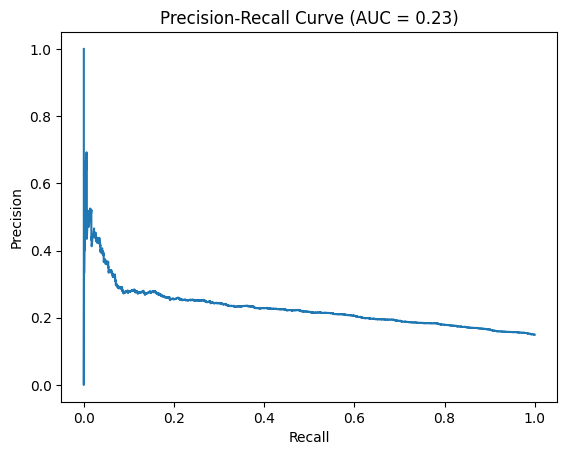

In [6]:
# --- Import Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, roc_auc_score,
                            precision_recall_curve, auc)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

# --- Data Loading & Preprocessing ---
# Load data
df = pd.read_csv("/content/customer_booking.csv", encoding="ISO-8859-1")

# Convert categoricals to category dtype
cat_cols = ['sales_channel', 'trip_type', 'route', 'booking_origin', 'flight_day']
for col in cat_cols:
    df[col] = df[col].astype('category')

# --- Feature Engineering ---
# Create meaningful features
df['total_addons'] = df[['wants_extra_baggage', 'wants_preferred_seat',
                        'wants_in_flight_meals']].sum(axis=1)
df['is_weekend'] = df['flight_day'].isin(['Sat', 'Sun']).astype(int)

# --- Train-Test Split ---
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Preprocessing Pipeline ---
# Separate categorical and numerical features
num_cols = X.select_dtypes(include=np.number).columns.tolist()

preprocessor = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42))
])

X_train_res, y_train_res = preprocessor.fit_resample(X_train[num_cols], y_train)

# --- Model Training with XGBoost ---
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'scale_pos_weight': [5]  # Counteract class imbalance
}

model = XGBClassifier(random_state=42, tree_method='hist')
search = RandomizedSearchCV(model, param_dist, n_iter=50,
                           scoring='roc_auc', cv=5, n_jobs=-1)
search.fit(X_train_res, y_train_res)

best_model = search.best_estimator_

# --- Evaluation ---
# Predict on test set
X_test_preprocessed = preprocessor.named_steps['scaler'].transform(X_test[num_cols])
y_proba = best_model.predict_proba(X_test_preprocessed)[:, 1]
y_pred = best_model.predict(X_test_preprocessed)

# Metrics
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Booking', 'Booking']))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AUC = {:.2f})'.format(auc(recall, precision)))
plt.show()



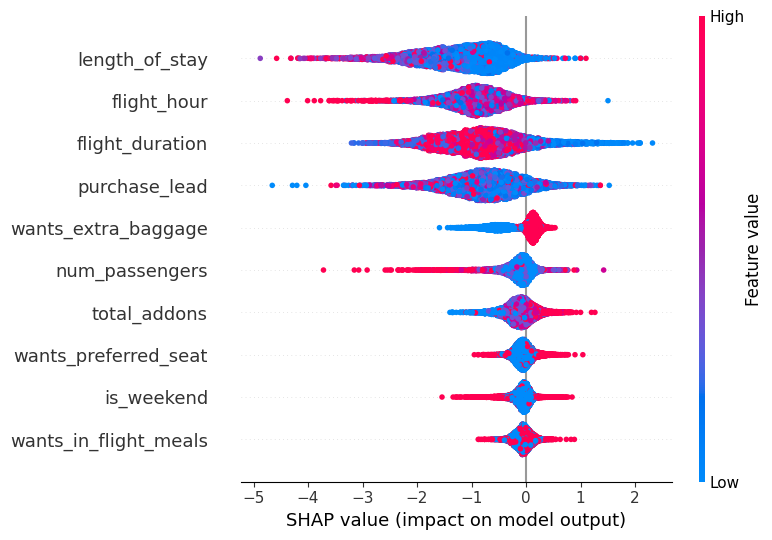

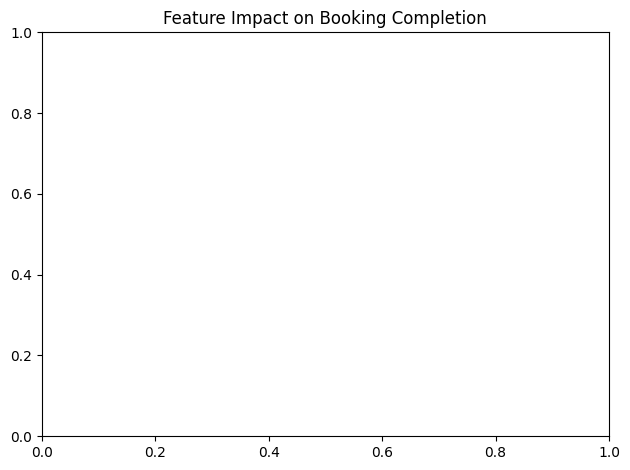

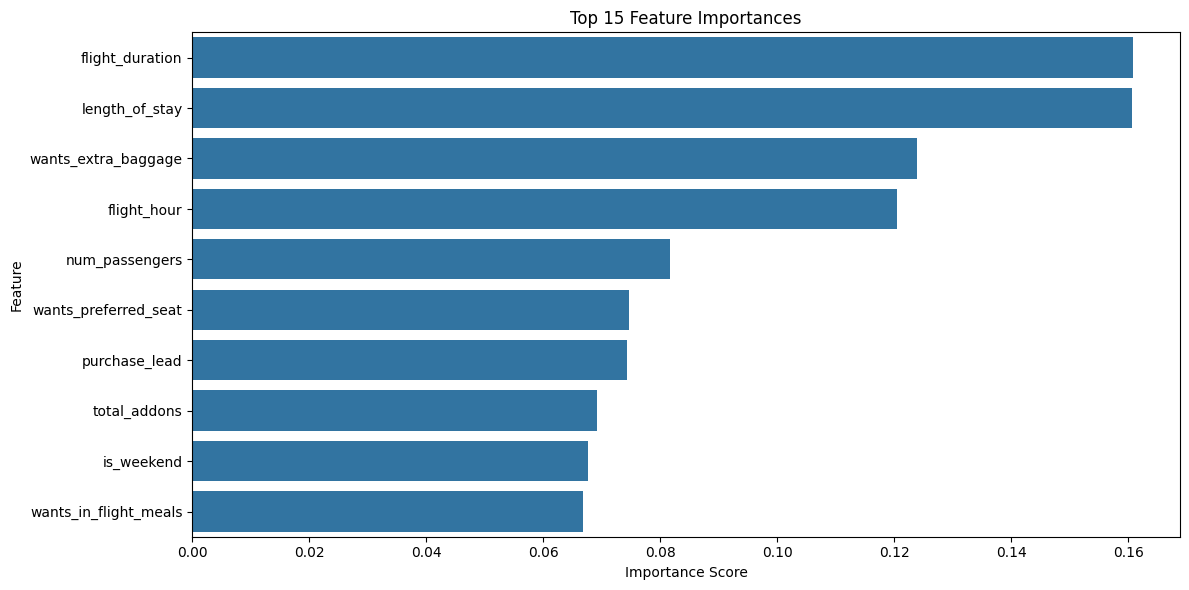

In [7]:
# --- SHAP Explanations ---
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_preprocessed)

plt.figure()
shap.summary_plot(shap_values, X_test_preprocessed,
                 feature_names=num_cols, plot_type='dot')
plt.title('Feature Impact on Booking Completion')
plt.tight_layout()
plt.show()

# --- Feature Importance Plot ---
feature_importance = pd.DataFrame({
    'feature': num_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

<ipython-input-14-7c621753f6ad>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


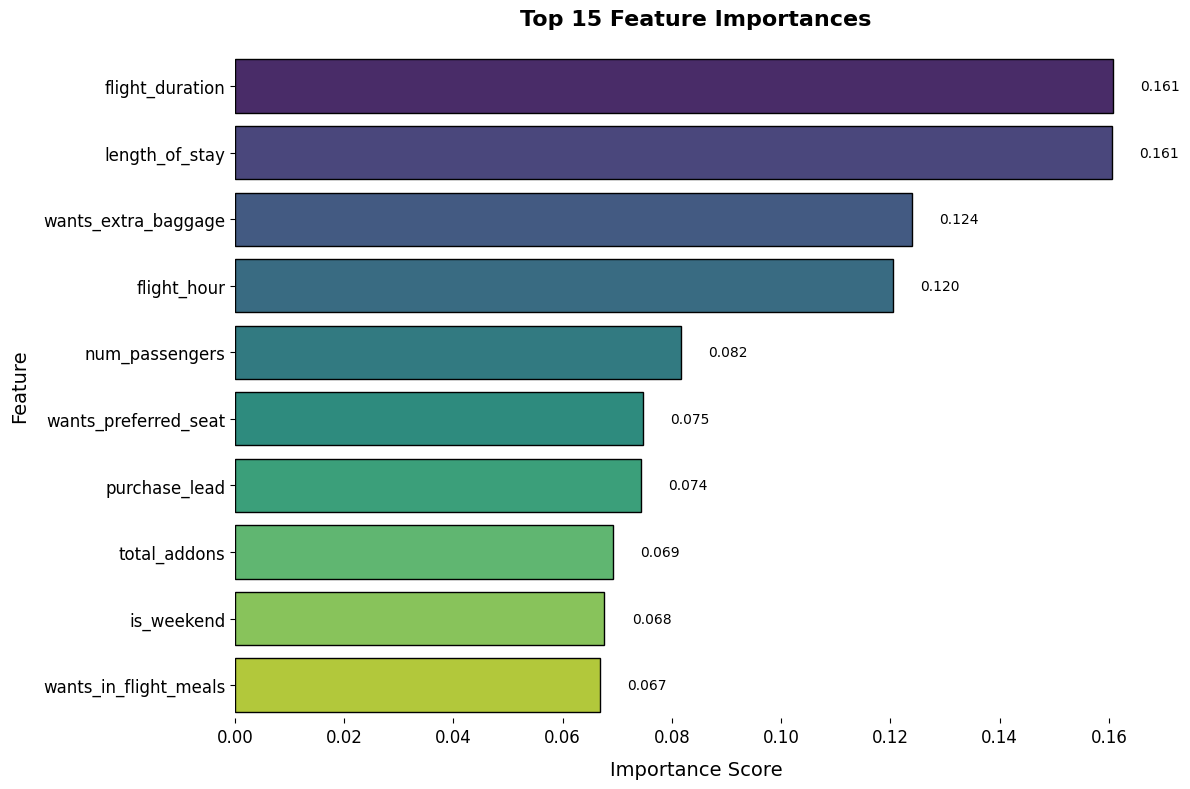

In [14]:
# Select top 15 features
top_features = feature_importance.head(15)

# Set a beautiful color palette
colors = sns.color_palette("viridis", len(top_features))

# Create the plot with enhanced aesthetics
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    x='importance',
    y='feature',
    data=top_features,
    palette=colors,
    edgecolor='black'
)

# Add value labels on the bars for better readability
for index, value in enumerate(top_features['importance']):
    barplot.text(value + 0.005, index, f"{value:.3f}", color='black', va='center')

# Add title and labels with improved font sizes
plt.title('Top 15 Feature Importances', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Importance Score', fontsize=14, labelpad=10)
plt.ylabel('Feature', fontsize=14, labelpad=10)

# Customize ticks for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove spines for a cleaner look
sns.despine(left=True, bottom=True)

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

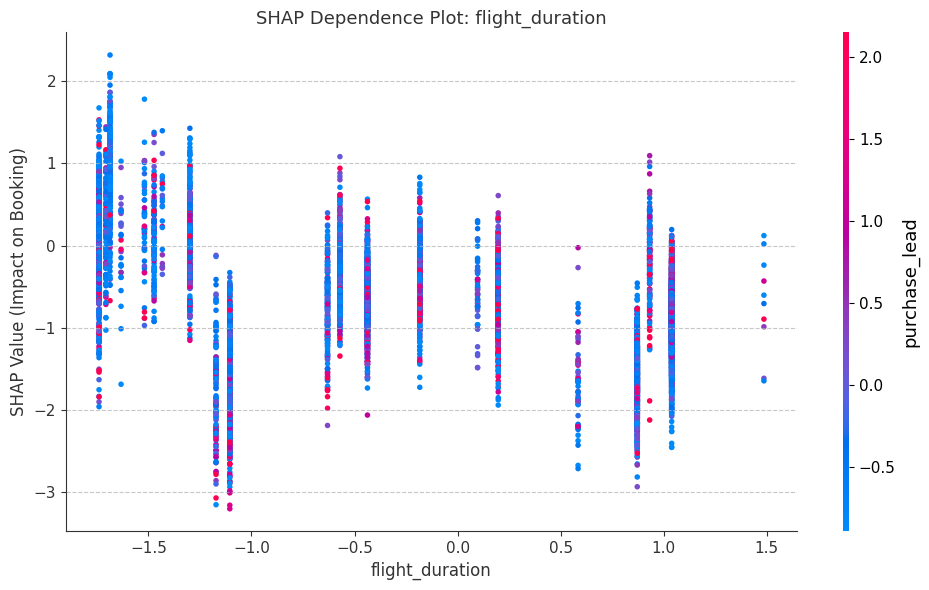

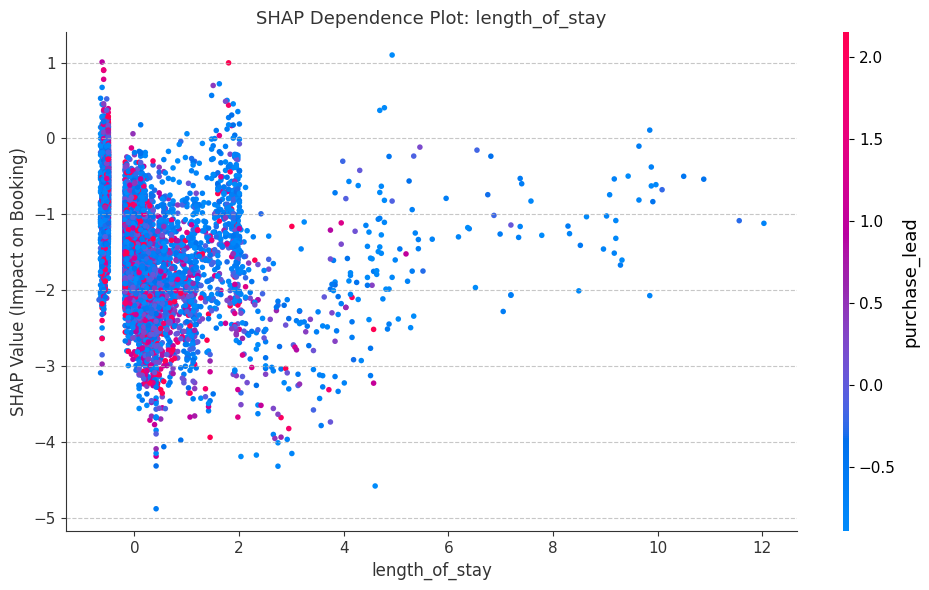

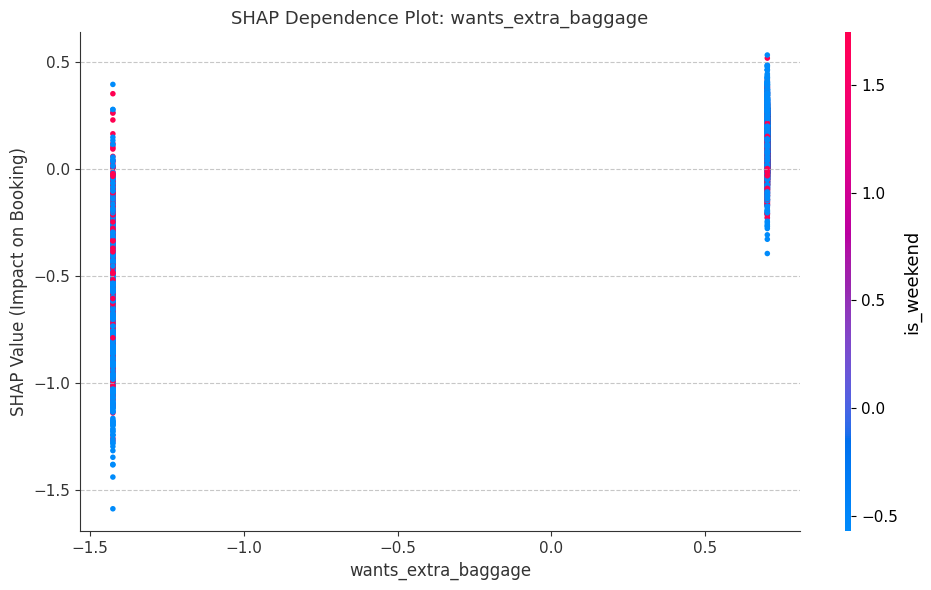

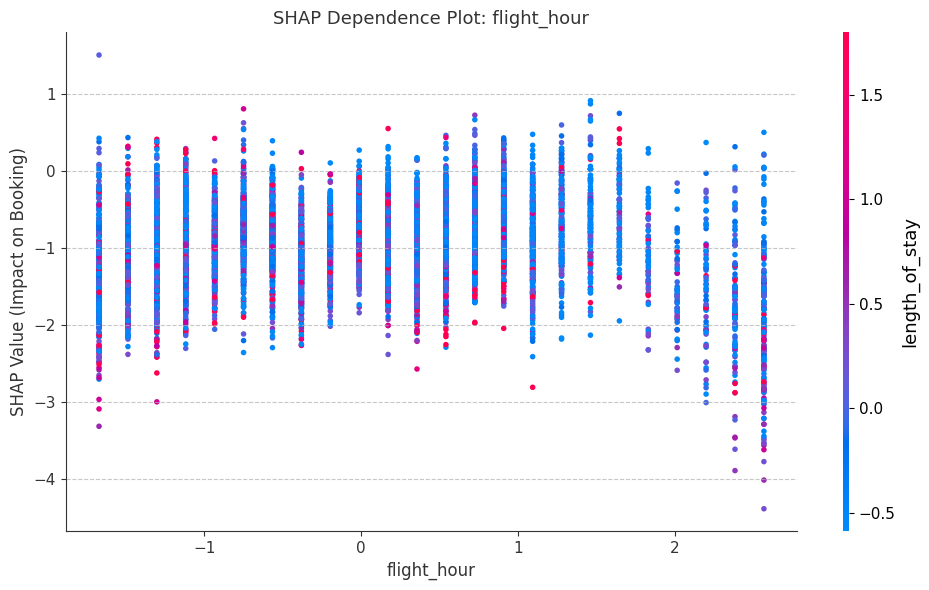

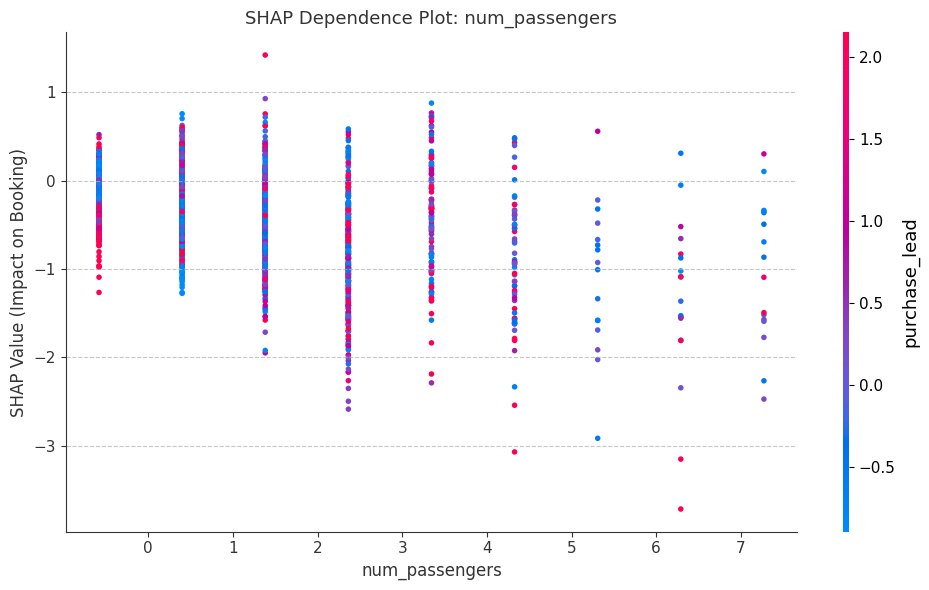

In [11]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.ioff()  # Disable automatic figure display

# --- SHAP Dependence Plots for Top Features ---
top_features = feature_importance.head(5)['feature'].tolist()

for feature in top_features:
    # Get feature index
    idx = num_cols.index(feature)

    # Create plot WITHOUT manual plt.figure()
    shap.dependence_plot(
        idx,
        shap_values,
        X_test_preprocessed,
        feature_names=num_cols,
        interaction_index='auto',
        show=False,  # Disable auto-show
        title=f'SHAP Dependence Plot: {feature}'
    )

    # Get current figure from SHAP
    fig = plt.gcf()
    fig.set_size_inches(10, 6)

    # Customize axes
    ax = plt.gca()
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('SHAP Value (Impact on Booking)', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Save and close
    plt.tight_layout()
    plt.savefig(f'shap_dependence_{feature}.png', bbox_inches='tight', dpi=300)
    plt.show()  # Clean up memory